# Introduction

This notebook demonstrates how to perform diffusivity and ionic conductivity analyses starting from a series of VASP AIMD simulations using Python Materials Genomics (pymatgen) and its add-on package pymatgen-analysis-diffusion. These notebooks are described in detail in

    Deng, Z.; Zhu, Z.; Chu, I.-H.; Ong, S. P. Data-Driven First-Principles Methods for the Study and Design of 
    Alkali Superionic Conductors. Chem. Mater. 2017, 29 (1), 281–288 DOI: 10.1021/acs.chemmater.6b02648.
    
If you find these notebooks useful and use the functionality demonstrated, please consider citing the above work.

Let's start by importing some modules and classes that we will be using.

In [ ]:
# Uncomment the subsequent lines in this cell to install dependencies for Google Colab.
# !pip install pymatgen==2022.7.19 pymatgen-analysis-diffusion

In [ ]:
from IPython.display import Image

%matplotlib inline

import collections
import json

import matplotlib.pyplot as plt
from pymatgen.analysis.diffusion.aimd.pathway import ProbabilityDensityAnalysis
from pymatgen.analysis.diffusion.aimd.van_hove import VanHoveAnalysis
from pymatgen.analysis.diffusion.analyzer import (
    DiffusionAnalyzer,
    get_arrhenius_plot,
    get_extrapolated_conductivity,
)
from pymatgen.core import Structure

# Preparation

The *DiffusionAnalyzer* class in pymatgen can be instantiated from a supplied list of sequential vasprun.xml output files from the AIMD simulations. An example code (commented out) is shown below.

In [ ]:
# files = ["run1/vasprun.xml", "run2/vasprun.xml", "run3/vasprun.xml"]
# analyzer = DiffusionAnalyzer.from_files(files, specie="Li", smoothed=False)

In this work, all trajectories are stored in an efficient document-based MongoDB database. The format of the documents in the database is a binary JSON format. Here, we will instead instantiate the *DiffusionAnalyzer* from a pre-serialized *DiffusionAnalyzer* for each temperature.

In [ ]:
temperatures = [600, 800, 1000, 1200]
analyzers = collections.OrderedDict()
for temp in temperatures:
    with open("aimd_data/%d.json" % temp) as f:
        d = json.load(f)
        analyzers[temp] = DiffusionAnalyzer.from_dict(d)

# MSD vs time plot

For each temperature, we can plot the mean square displacement against time as follows (only 1000 K shown).

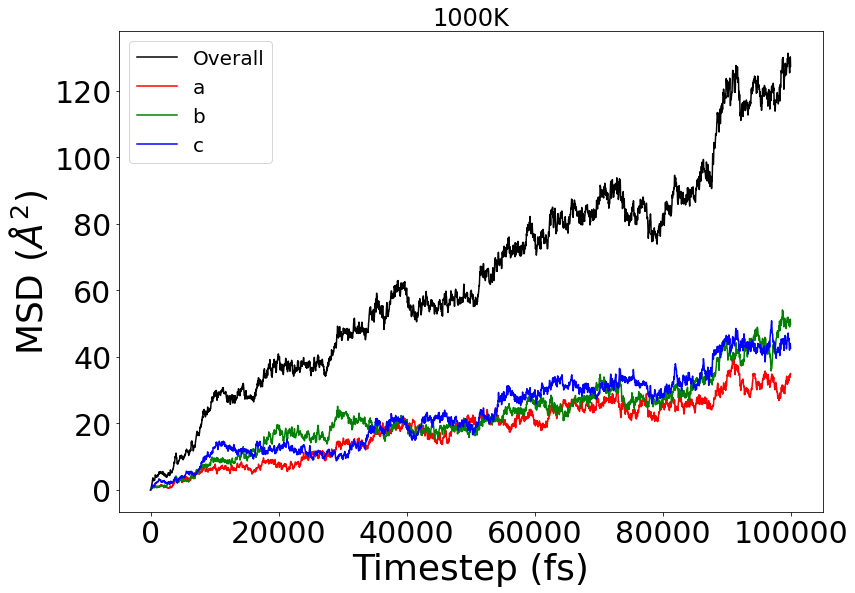

In [ ]:
plt = analyzers[1000].get_msd_plot()
title = plt.title("1000K", fontsize=24)

# Activation energy and ionic conductivity

From diffusivity at each temperature, we can obtain activation energy and room temperature ionic conductivity by constructing an Arrhenius plot. 

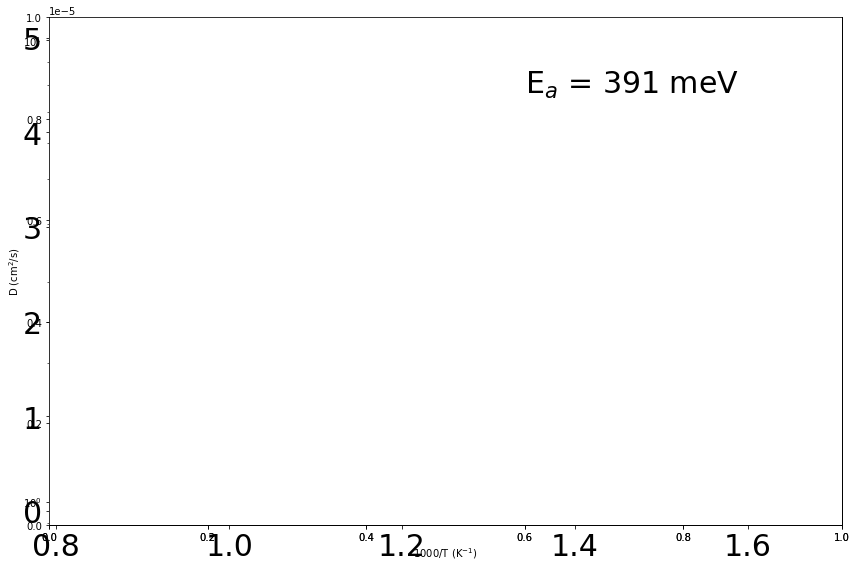

In [ ]:
diffusivities = [d.diffusivity for d in analyzers.values()]

plt = get_arrhenius_plot(temperatures, diffusivities)

From the temperatures and diffusivities, one may obtained the extrapolated room-temperature conductivity as follows.

In [ ]:
rts = get_extrapolated_conductivity(
    temperatures,
    diffusivities,
    new_temp=300,
    structure=analyzers[800].structure,
    species="Li",
)
print("The Li ionic conductivity for Li6PS5Cl at 300 K is %.4f mS/cm" % rts)

The Li ionic conductivity for Li6PS5Cl at 300 K is 0.0730 mS/cm


# Probability density function analysis

We can compute the probability density function from the AIMD trajectories using the *ProbabilityDensityAnalysis* class implemented in the pymatgen-diffusion add-on. We will use the calculation at 800K as an example. The probability density function can then be output to a CHGCAR-like file for visualization in VESTA.

In [ ]:
structure = analyzers[800].structure
trajectories = [s.frac_coords for s in analyzers[800].get_drift_corrected_structures()]
pda = ProbabilityDensityAnalysis(structure, trajectories, species="Li")
pda.to_chgcar(
    "aimd_data/CHGCAR.vasp"
)  # Output to a CHGCAR-like file for visualization in VESTA.

The VESTA visualization software can be used to visualize isosurfaces in the probability density. The 800K probability density function at an isosurface of 0.002 is shown below.

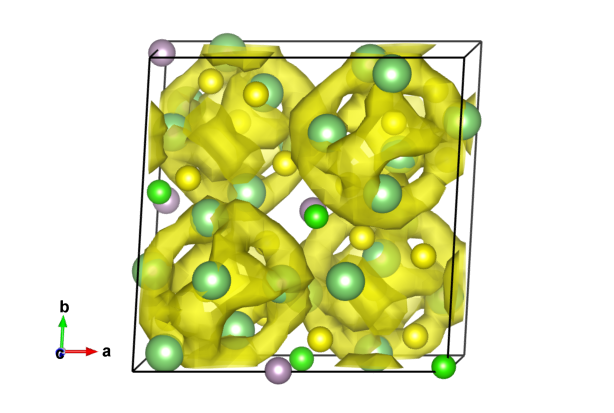

In [ ]:
Image(filename="aimd_data/Isosurface_800K_0.png")

# van Hove correlation function analysis

We can compute the van Hove correlation function from a *DiffusionAnalyzer* using the *VanHoveAnalysis* class implemented in the pymatgen-diffusion add-on. We will use the calculation at 800K as an example. 

In [ ]:
vha = VanHoveAnalysis(analyzers[800])

We can then plot the self ($G_s$) and distinct ($G_d$) parts of the van Hove correlation function as follows.

<module 'matplotlib.pyplot' from '/Users/shyue/miniconda3/envs/mavrl/lib/python3.9/site-packages/matplotlib/pyplot.py'>

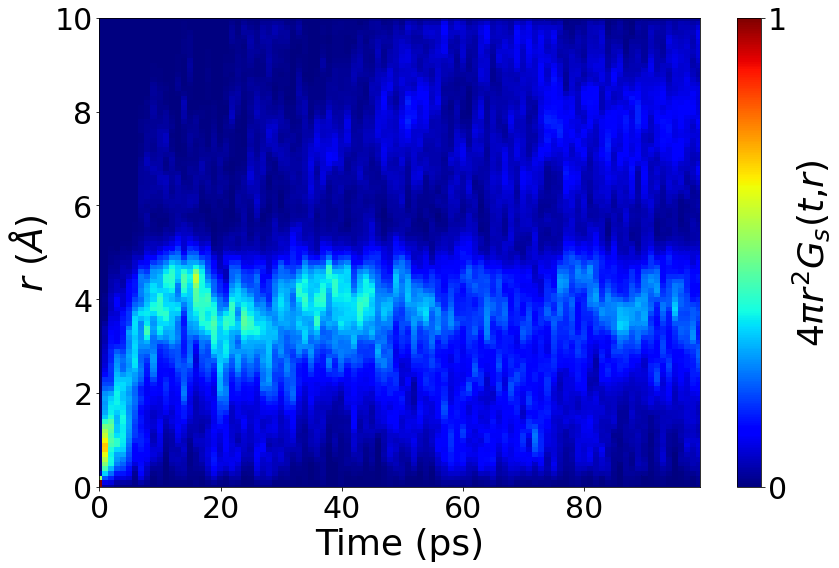

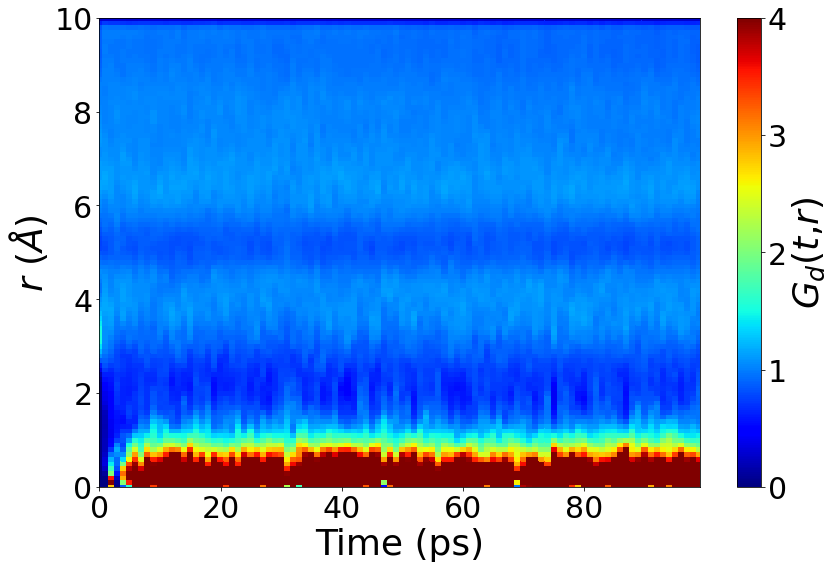

In [ ]:
vha.get_3d_plot(mode="self")
vha.get_3d_plot(mode="distinct")